In [1]:
%config Completer.use_jedi = False
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
import os
import random
from collections import Counter

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from collections import Counter

In [3]:
csv_data = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
image_data = r'../input/siim-isic-melanoma-classification/jpeg/train'
csv_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
csv_data.shape

(33126, 8)

dict_values([32542, 584])


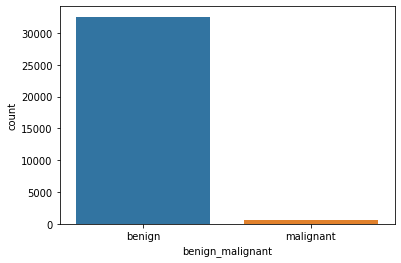

In [5]:
sns.countplot(x='benign_malignant', data=csv_data)
print(Counter(csv_data['benign_malignant']).values())

In [6]:
malignant_data = csv_data[csv_data['benign_malignant'] == 'malignant']
benign_data = csv_data[csv_data['benign_malignant'] == 'benign'][:5000]

malignant_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1


In [7]:
img_size = 224

m_t_size = 400
b_t_size = 4000
m_v_size = 184
b_v_size = 1000

In [8]:
X_train_m, y_train_m = malignant_data[:m_t_size], [1]*m_t_size
X_train_b, y_train_b = benign_data[:b_t_size], [0]*b_t_size

X_valid_m, y_valid_m = malignant_data[m_t_size:], [1]*m_v_size
X_valid_b, y_valid_b = benign_data[b_t_size:], [0]*b_v_size

In [9]:
print(len(X_train_m), len(X_valid_m), len(X_train_b), len(X_valid_b))

print(Counter(y_train_m), Counter(y_valid_m), Counter(y_train_b))

400 184 4000 1000
Counter({1: 400}) Counter({1: 184}) Counter({0: 4000})


In [10]:
def color_constancy(img, power=6, gamma=None):
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256): look_up_table[i][0] = 255*pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)
    
    return img.astype(img_dtype)

def img_processing(input_df, y_val):
    processed_data = []
    for i in range(input_df.shape[0]):
        img = cv2.imread(os.path.join(image_data, input_df['image_name'].iloc[i] + '.jpg'))
        img = color_constancy(img, power=8)
        img = cv2.GaussianBlur(img, (7, 7), 0)
    #     img = cv2.erode(img, kernel=np.ones((5,5), np.uint8), iterations=5)
    #     img = cv2.dilate(img, kernel=np.ones((5,5), np.uint8), iterations=5)
        img = cv2.resize(img, (img_size, img_size))
        processed_data.append([img, y_val])
        
    return processed_data


In [11]:
%%time
training_data, valid_data = [], []
X_train, y_train, X_valid, y_valid = [], [], [], []

training_data.extend(img_processing(X_train_b, 0))
training_data.extend(img_processing(X_train_m, 1))

random.shuffle(training_data)
for feature, label in training_data:
    X_train.append(feature)
    y_train.append(label)
    
X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

valid_data.extend(img_processing(X_valid_b, 0))
valid_data.extend(img_processing(X_valid_m, 1))

random.shuffle(valid_data)
for feature, label in valid_data:
    X_valid.append(feature)
    y_valid.append(label)
    
X_valid = np.array(X_valid).reshape(-1, img_size, img_size, 3)
y_valid = np.array(y_valid)

CPU times: user 1h 39min 28s, sys: 11min 31s, total: 1h 51min
Wall time: 1h 48min 34s


In [12]:
print(len(X_train), len(X_valid))

print(Counter(y_train), Counter(y_valid))

4400 1184
Counter({0: 4000, 1: 400}) Counter({0: 1000, 1: 184})


## Data Preprocess Trails

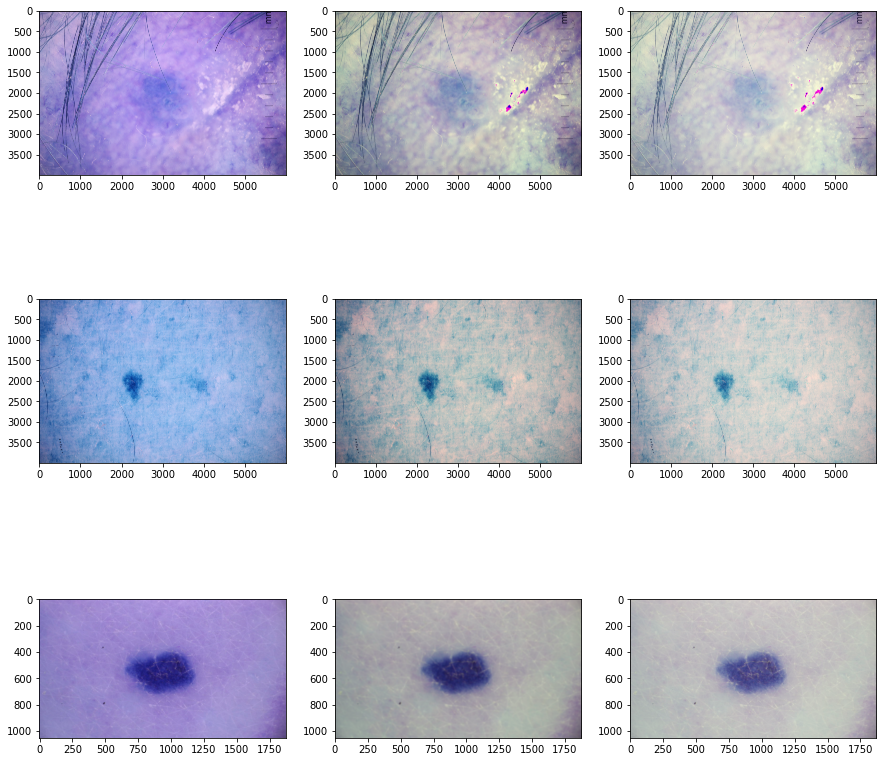

In [24]:
cnt = 0
samples = 3
fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
for i in range(X_train_b.shape[0]):
    img = cv2.imread(os.path.join(image_data, X_train_b['image_name'].iloc[i] + '.jpg'))
    
    img0 = color_constancy(img, power=8)
    img0 = cv2.GaussianBlur(img0, (15, 15), 0)
    
    img1 = color_constancy(img, power=6, gamma=1.5)
    img0 = cv2.GaussianBlur(img0, (15, 15), 0)
    
    ax[cnt, 0].imshow(img)
    ax[cnt, 1].imshow(img0)
    ax[cnt, 2].imshow(img1)
    cnt += 1
    if cnt == samples:
        break

plt.show()

In [ ]:
print('Malignant Image')
cnt = 0
fig, ax = plt.subplots(5, 3, figsize=(15, 15))
for i in range(csv_data.shape[0]):
    if csv_data['benign_malignant'].iloc[i] == 'malignant':
        img = cv2.imread(os.path.join(image_data, csv_data['image_name'].iloc[i] + '.jpg'))
        img0 = cv2.GaussianBlur(img, (13, 13), 0)
#         img0 = cv2.erode(img0, kernel=np.ones((5,5), np.uint8), iterations=5)
#         img0 = cv2.dilate(img0, kernel=np.ones((5,5), np.uint8), iterations=5)
        img0 = cv2.resize(img0, (img_size, img_size))
        
        img1 = cv2.medianBlur(img, 5)
        img1 = cv2.erode(img1, kernel=np.ones((5,5), np.uint8), iterations=1)
        img1 = cv2.resize(img1, (img_size, img_size))
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == 5:
            break

plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
print('Benign Image')
cnt = 0
fig, ax = plt.subplots(5, 3, figsize=(15, 15))
for i in range(csv_data.shape[0]):
    if csv_data['benign_malignant'].iloc[i] == 'benign':
        img = cv2.imread(os.path.join(image_data, csv_data['image_name'].iloc[i] + '.jpg'))
        img0 = cv2.GaussianBlur(img, (5, 5), 0)
        img0 = cv2.erode(img0, kernel=np.ones((5,5), np.uint8), iterations=5)
        img0 = cv2.dilate(img0, kernel=np.ones((5,5), np.uint8), iterations=5)
        img0 = cv2.resize(img0, (img_size, img_size))
        
        img1 = cv2.medianBlur(img, 5)
        img1 = cv2.erode(img1, kernel=np.ones((5,5), np.uint8), iterations=1)
        img1 = cv2.resize(img1, (img_size, img_size))
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == 5:
            break

plt.xticks([]), plt.yticks([])
plt.show()

### Observations
The data is highly imbalanced 

- Trying out SMOTE Balancing
- Data Augmentation

In [ ]:
%%time
X, y = [], []

for i in range(benign_data.shape[0]):
    img = cv2.imread(os.path.join(image_data, benign_data['image_name'].iloc[i] + '.jpg'))
    img = cv2.GaussianBlur(img, (7, 7), 0)
#     img = cv2.erode(img, kernel=np.ones((5,5), np.uint8), iterations=5)
#     img = cv2.dilate(img, kernel=np.ones((5,5), np.uint8), iterations=5)
    img = cv2.resize(img, (img_size, img_size))
    X.append(img)
    y.append(benign_data['target'].iloc[i])

for i in range(malignant_data.shape[0]):
    img = cv2.imread(os.path.join(image_data, malignant_data['image_name'].iloc[i] + '.jpg'))
    img = cv2.GaussianBlur(img, (7, 7), 0)
#     img = cv2.erode(img, kernel=np.ones((5,5), np.uint8), iterations=5)
#     img = cv2.dilate(img, kernel=np.ones((5,5), np.uint8), iterations=5)
    img = cv2.resize(img, (img_size, img_size))
    X.append(img)
    y.append(malignant_data['target'].iloc[i])

X = np.array(X).reshape(-1, img_size, img_size, 3)

In [ ]:
len(X)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=360, horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

## Model Building

In [13]:
effb0_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])

2021-11-18 15:10:12.479961: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 15:10:12.596689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 15:10:12.597472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 15:10:12.599199: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])

for layer in resnet_model.layers: layer.trainable = False

from keras.models import Model

output = model.layers[-1].output
output = Flatten()(output)
resnet_model = Model(model.input, output)

for layer in resnet_model.layers:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(Dense(512, input_shape=X_train.shape[1:]))
model.add(BatchNormalization(3))
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.3))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [14]:
model = Sequential()
model.add(effb0_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,055,972
Trainable params: 4,011,389
Non-trainable params: 44,583
_________________________________________________________________


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                                             decay_steps=10000, decay_rate=0.9)
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [15]:
from keras import backend as K

def calculate_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def calculate_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def calculate_f1(y_true, y_pred):
    precision = calculate_precision(y_true, y_pred)
    recall = calculate_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer='adam', metrics=['accuracy'])

In [16]:
new_weights = {
    0: X_train.shape[0]/(2*Counter(y_train)[0]),
    1: X_train.shape[0]/(2*Counter(y_train)[1])
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 0.55, 1: 5.5}

In [17]:
history = model.fit(X_train, y_train, batch_size=8, epochs=20, validation_data=(X_valid, y_valid), class_weight=new_weights)
# history = model.fit_generator(train_generator, epochs=10, validation_data=val_generator)

2021-11-18 15:10:17.345856: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 662323200 exceeds 10% of free system memory.
2021-11-18 15:10:18.158590: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 662323200 exceeds 10% of free system memory.
2021-11-18 15:10:18.659314: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-11-18 15:10:26.351256: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


550/550 [==============================] - 56s 78ms/step - loss: 0.1299 - accuracy: 0.7684 - val_loss: 0.0388 - val_accuracy: 0.8378
Epoch 2/20
550/550 [==============================] - 42s 77ms/step - loss: 0.1086 - accuracy: 0.8016 - val_loss: 0.0514 - val_accuracy: 0.8412
Epoch 3/20
550/550 [==============================] - 40s 74ms/step - loss: 0.0831 - accuracy: 0.8211 - val_loss: 0.0422 - val_accuracy: 0.8438
Epoch 4/20
550/550 [==============================] - 42s 77ms/step - loss: 0.0811 - accuracy: 0.8225 - val_loss: 0.1940 - val_accuracy: 0.8285
Epoch 5/20
550/550 [==============================] - 42s 76ms/step - loss: 0.1019 - accuracy: 0.8107 - val_loss: 0.0642 - val_accuracy: 0.8302
Epoch 6/20
550/550 [==============================] - 42s 76ms/step - loss: 0.0726 - accuracy: 0.8348 - val_loss: 0.9246 - val_accuracy: 0.5760
Epoch 7/20
550/550 [==============================] - 42s 76ms/step - loss: 0.0772 - accuracy: 0.8300 - val_loss: 0.0471 - val_accuracy: 0.8319
Epo

In [18]:
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))
# conf = plot_confusion_matrix(model, X_valid, y_valid)

37/37 [==============================] - 3s 31ms/step
              precision    recall  f1-score   support

           0       0.84      1.00      0.92      1000
           1       0.00      0.00      0.00       184

    accuracy                           0.84      1184
   macro avg       0.42      0.50      0.46      1184
weighted avg       0.71      0.84      0.77      1184

[[1000    0]
 [ 184    0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()